In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [2]:
def plot_loss_accuracy(history):
    '''
    A function to plot train and validation loss against epochs of training
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())+0.5])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [3]:
# using ImageDataGenerator to load data from the disk

train_val_directory_path = 'chart_images_dataset/charts/train_val'

train_csv_path = 'train.csv'
val_csv_path   = 'val.csv'

train_df = pd.read_csv(train_csv_path)
val_df   = pd.read_csv(val_csv_path)

IMAGE_SIZE = 128
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) # 3 channels
NUM_OF_CLASSES = 5


# scaling the image pixels b/w 0-1
image_generator = ImageDataGenerator( rescale=1./255  )

train_data_gen = image_generator.flow_from_dataframe(
    train_df, 
    directory=train_val_directory_path, 
    x_col='image_filename', 
    y_col='type', 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=32, 
    shuffle=False, # already shuffled 
    seed=None,
    interpolation='nearest', 
    validate_filenames=True
)

val_data_gen = image_generator.flow_from_dataframe(
    val_df, 
    directory=train_val_directory_path, 
    x_col='image_filename', 
    y_col='type', 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=32, 
    shuffle=False, # already shuffled 
    seed=None,
    interpolation='nearest', 
    validate_filenames=True

)

Found 800 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.


indices of categories : {'dot_line': 0, 'hbar_categorical': 1, 'line': 2, 'pie': 3, 'vbar_categorical': 4}
shape of a batch given by image data generator : (32, 128, 128, 3)


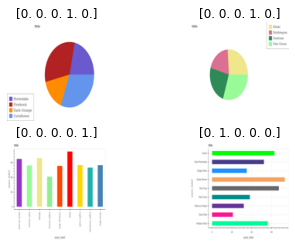

In [4]:
# checking/ validating some images generated by datagenerator

print ('indices of categories : {}'.format(train_data_gen.class_indices))

# This function will plot 4 images along with their labels.
def plotImages(image_datas,y_list):
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(image_datas[0], cmap='gray')
    axarr[0,0].set_title(y_list[0])
    axarr[0,0].axis('off')
    axarr[0,1].imshow(image_datas[1], cmap='gray')
    axarr[0,1].set_title(y_list[1])
    axarr[0,1].axis('off')
    axarr[1,0].imshow(image_datas[2], cmap='gray')
    axarr[1,0].set_title(y_list[2])
    axarr[1,0].axis('off')
    axarr[1,1].imshow(image_datas[3], cmap='gray')
    axarr[1,1].set_title(y_list[3])
    axarr[1,1].axis('off')

sample_training_images, y_list = next(train_data_gen)
sample_training_images = np.squeeze(sample_training_images) # to reduce dimension
print("shape of a batch given by image data generator : {}".format(sample_training_images.shape))

plotImages(sample_training_images[:4],y_list[:4])

### Trying 2 layer CNNs 

Having Convulation Layers: with variable filters, kernel size = (3,3) and stride = (1,1) 

Having Maxpooling after each convulation layer: with pool size = (2,2)  and stride = (2,2)

In [37]:
def create_two_layer_CNN_model():
    '''
    Creates a model with 2 convulation layers
    '''

    model = tf.keras.models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMAGE_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
  
    layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),

    layers.Dense(NUM_OF_CLASSES, activation='softmax') 
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [38]:
two_layer_CNN_model = create_two_layer_CNN_model()
two_layer_CNN_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1843328   
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [39]:
# training

two_layer_CNN_checkpoint_filepath = 'two_layer_CNN/checkpoint/'
two_layer_CNN_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=two_layer_CNN_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

two_layer_CNN_model_history = two_layer_CNN_model.fit(train_data_gen, epochs=50, 
                    validation_data=val_data_gen,
                    callbacks=[two_layer_CNN_checkpoint_callback, early_stopping_callback])

Epoch 1/50
25/25 [==============================] - 11s 439ms/step - loss: 1.2851 - accuracy: 0.4850 - val_loss: 0.5608 - val_accuracy: 0.8200
Epoch 2/50
25/25 [==============================] - 10s 411ms/step - loss: 0.4847 - accuracy: 0.7962 - val_loss: 0.2827 - val_accuracy: 0.9050
Epoch 3/50
25/25 [==============================] - 10s 394ms/step - loss: 0.2820 - accuracy: 0.8900 - val_loss: 0.2140 - val_accuracy: 0.9300
Epoch 4/50
25/25 [==============================] - 10s 390ms/step - loss: 0.1721 - accuracy: 0.9375 - val_loss: 0.1421 - val_accuracy: 0.9450
Epoch 5/50
25/25 [==============================] - 9s 358ms/step - loss: 0.1061 - accuracy: 0.9600 - val_loss: 0.0949 - val_accuracy: 0.9650
Epoch 6/50
25/25 [==============================] - 10s 389ms/step - loss: 0.0808 - accuracy: 0.9737 - val_loss: 0.0818 - val_accuracy: 0.9750
Epoch 7/50
25/25 [==============================] - 9s 377ms/step - loss: 0.0617 - accuracy: 0.9875 - val_loss: 0.0781 - val_accuracy: 0.9800
E

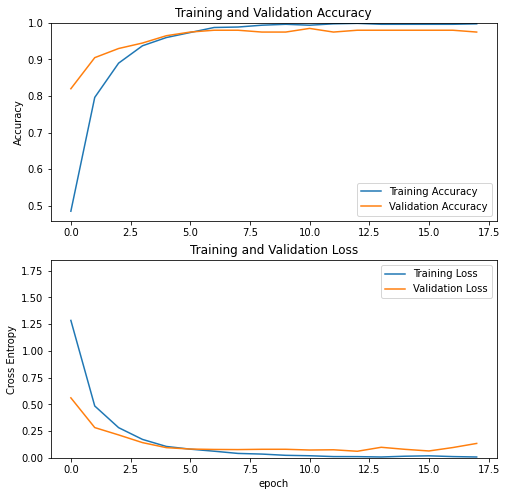

In [41]:
plot_loss_accuracy(two_layer_CNN_model_history)

In [42]:
# evaluating validation data with best weights form the training

two_layer_CNN_model.load_weights(two_layer_CNN_checkpoint_filepath)
two_layer_CNN_model.evaluate(val_data_gen)

7/7 [==============================] - 1s 110ms/step - loss: 0.0728 - accuracy: 0.9850


[0.07282385230064392, 0.9850000143051147]

### Observations
(a,b) : CNN with a and b number filters

* (8,8) : 
    * Overfitting but performs quite good with val_acc = 97.50% and train_acc = 100%
* (16,8) :
    * slightly better than (8,8) with val_acc = 99.00% and train_acc = 100%
* (16,16) : very similar to (16,8) 
    * Clear overfitting but performing really with val_acc = 98.50% and train_acc = 100%
* (32, 8) : very similar to (16,16) 
    * slightly more overfitting : val_acc: 98.50% train_acc= 100%
* (32,16) : very similar to (32,8) : but slightly more over fitting
    *  with val_acc = 97.50% and train_acc = 100% 
* (64, 8) : very similar to (32,16) : but slightly more over fitting in terms of loss
    * More and more overfitting : performs worse than the above ones : val_acc = 98.00% train_acc : 100%

Increasing model complexity is increasing overfitting while the accuracy is more or less same for all 98-99%

**Sweet Spot** : (16,8), (16,16) : complex enough to learn, not too complex to overfit
